How to calculate the Iris code and some examples

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


Find the pupil and iris center for an image

In [39]:
from IrisSegmentation import FindPupilIris, LocateEyelids, LocateEyelids2, EyelidFitter
from util import rgbtogray
%load_ext autoreload
%autoreload 2

#img_use = cv2.imread("UTIRIS_infrared/021/021_L/Img_021_L_5.bmp").astype(np.double)[: , :, 0] / 255

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
img = rgbtogray(cv2.imread("UTIRIS_infrared/021/021_L/Img_021_L_5.bmp").astype(np.double)/255.)

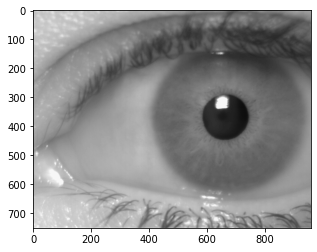

In [41]:
plt.imshow(img, cmap="gray", vmin=0., vmax=1.)

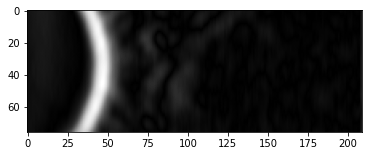

dist right:  52.5
dist right:  52.5


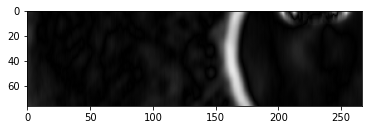

dist left:  103.0


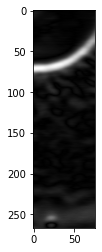

dist top:  73.0


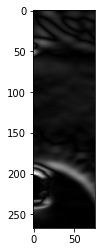

dist bottom:  67.0


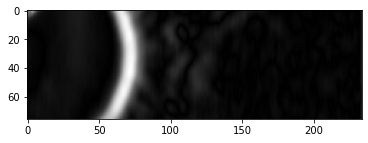

dist right:  77.5
dist right:  77.5


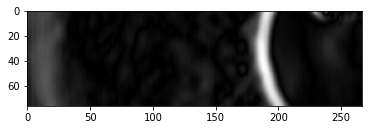

dist left:  78.0


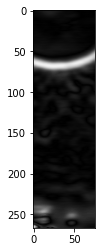

dist top:  74.0


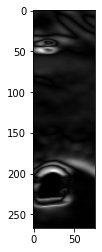

dist bottom:  74.0


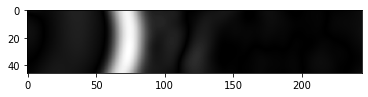

79.0 79.0


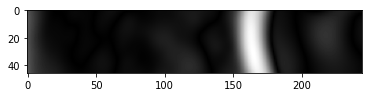

93.0 169.0
Estimated pupil radius:  86
Estimated pupil center:  [375, 670]
Optimal location and radius:  
x=664.0
y=369.0
r=79.0
Estimated iris radius:  234
Optimal location and radius:  
x=671.0
y=376.0
r=258.0


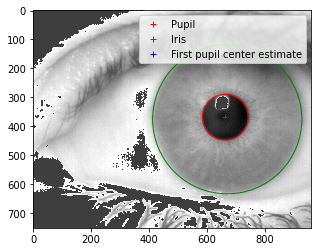

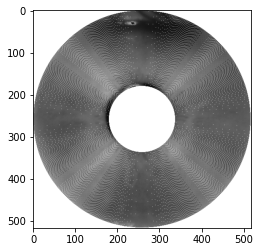

In [42]:
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)

In [43]:
print(pup_center, pup_r, iris_center, iris_r)

(369, 664) 79 (376, 671) 258


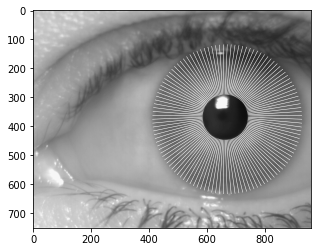

In [44]:
from util import transform_iris
from iriscode import calculate_iris_code
theta_psize = 15
n_theta_patches = 8
rho_psize = 15
n_rho_patches = 8

# It seems like the function FindPupilIris changes img (!), which is passed by refrence. Hence, I reload it here.
img = rgbtogray(cv2.imread("UTIRIS_infrared/021/021_L/Img_021_L_5.bmp").astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r,
                            theta_res = theta_psize*n_theta_patches,
                            rho_res = rho_psize*n_rho_patches,
                            method = "Daug", plot = True)


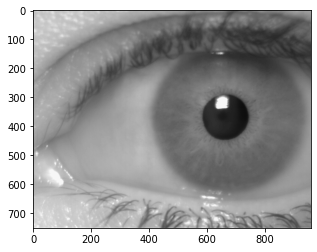

In [49]:
plt.imshow(img, cmap="gray", vmin=0., vmax=1.)

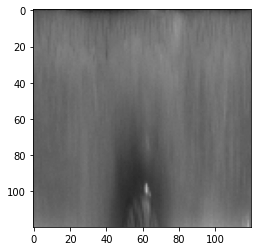

In [50]:
plt.imshow(transf_img, cmap="gray", vmin=0., vmax=1.)

In [61]:
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, 
                alpha=0.4, omega=4)

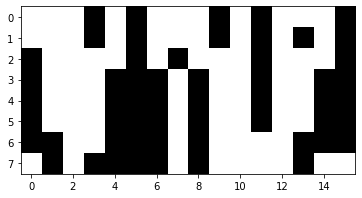

In [62]:
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)


Messing with the parameters alpha and omega will change the code significantly, so the next step is to concatenate the code for various values of alpha and omega and maybe rotations of the iris.

## Testing the code with the same and different eyes.

### Same eye

Using the same settings as above

In [63]:
name1 = "UTIRIS_infrared/021/021_L/Img_021_L_5.bmp"
name2 = "UTIRIS_infrared/021/021_L/Img_021_L_3.bmp"

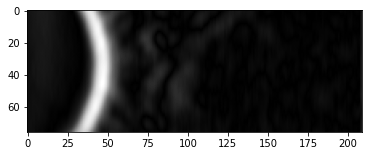

dist right:  52.5
dist right:  52.5


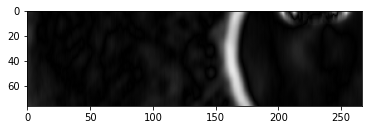

dist left:  103.0


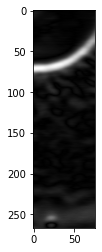

dist top:  73.0


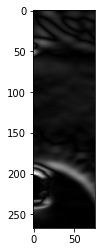

dist bottom:  67.0


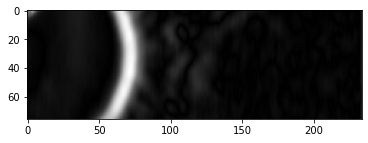

dist right:  77.5
dist right:  77.5


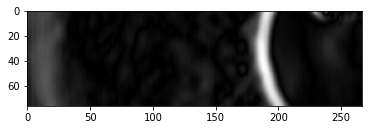

dist left:  78.0


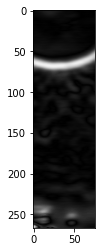

dist top:  74.0


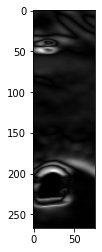

dist bottom:  74.0


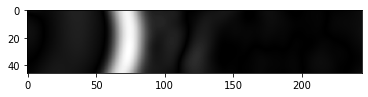

79.0 79.0


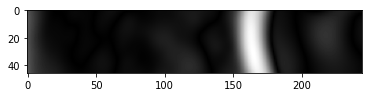

93.0 169.0
Estimated pupil radius:  86
Estimated pupil center:  [375, 670]
Optimal location and radius:  
x=664.0
y=369.0
r=79.0
Estimated iris radius:  234
Optimal location and radius:  
x=671.0
y=376.0
r=258.0


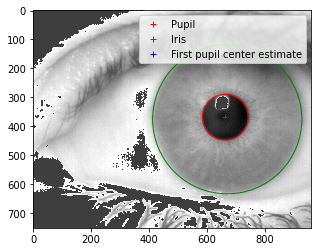

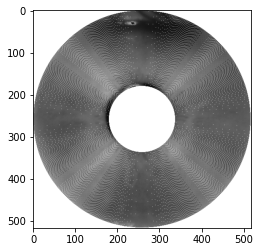

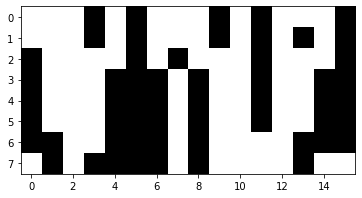

In [64]:
img = rgbtogray(cv2.imread(name1).astype(np.double)/255.)
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
img = rgbtogray(cv2.imread(name1).astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res = theta_psize*n_theta_patches, 
                            rho_res = rho_psize*n_rho_patches,method = "Daug", plot = True)
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, alpha=0.4, omega=4)
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)


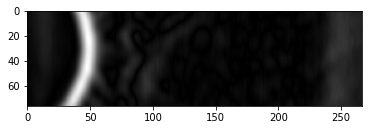

dist right:  55.0


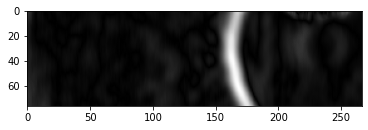

dist left:  102.0


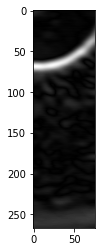

dist top:  71.0


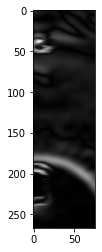

dist bottom:  77.5


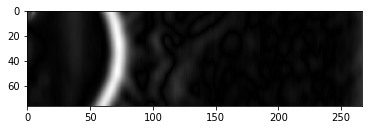

dist right:  79.0


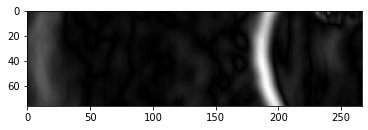

dist left:  78.0


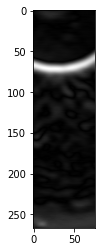

dist top:  78.0


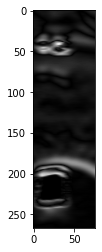

dist bottom:  76.5


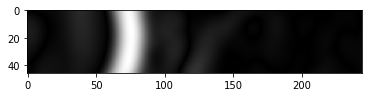

80.0 80.0


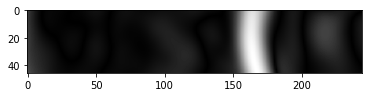

93.0 169.0
Estimated pupil radius:  86
Estimated pupil center:  [359, 577]
Optimal location and radius:  
x=571.0
y=352.0
r=80.0
Estimated iris radius:  239
Optimal location and radius:  
x=579.0
y=361.0
r=263.0


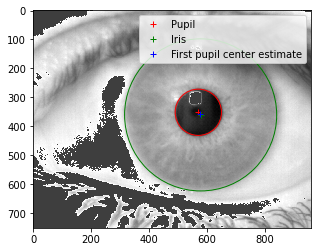

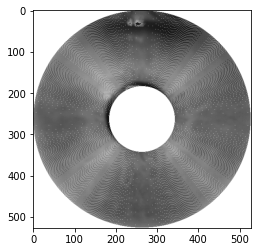

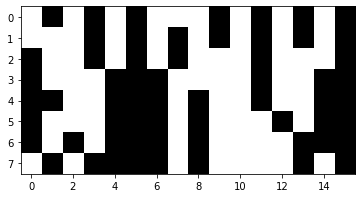

In [65]:
img = rgbtogray(cv2.imread(name2).astype(np.double)/255.)
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
img = rgbtogray(cv2.imread(name2).astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res = theta_psize*n_theta_patches, 
                            rho_res = rho_psize*n_rho_patches,method = "Daug", plot = True)
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, alpha=0.4, omega=4)
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)


They are not exactly the same but there are obviously similarities!

### Different eyes

In [66]:
name1 = "UTIRIS_infrared/021/021_L/Img_021_L_5.bmp"
name2 = "UTIRIS_infrared/062/062_R/Img_062_R_5.bmp"

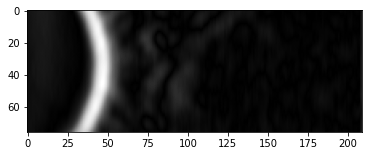

dist right:  52.5
dist right:  52.5


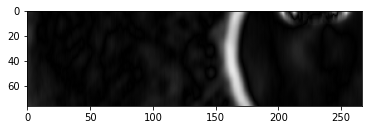

dist left:  103.0


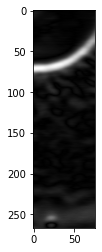

dist top:  73.0


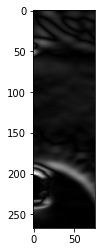

dist bottom:  67.0


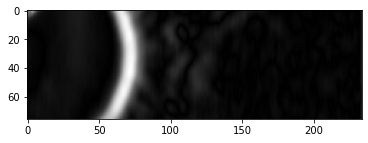

dist right:  77.5
dist right:  77.5


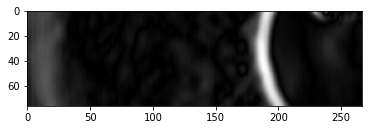

dist left:  78.0


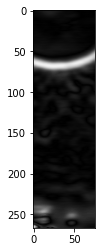

dist top:  74.0


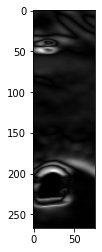

dist bottom:  74.0


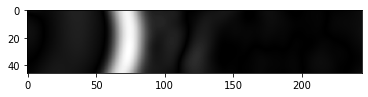

79.0 79.0


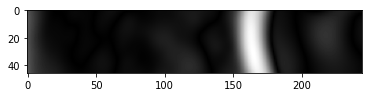

93.0 169.0
Estimated pupil radius:  86
Estimated pupil center:  [375, 670]
Optimal location and radius:  
x=664.0
y=369.0
r=79.0
Estimated iris radius:  234
Optimal location and radius:  
x=671.0
y=376.0
r=258.0


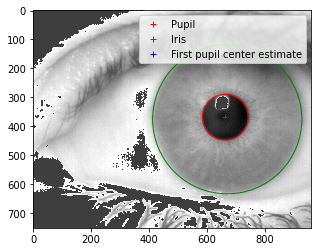

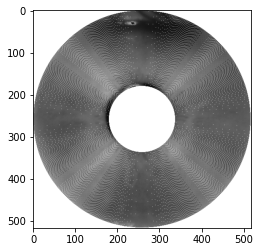

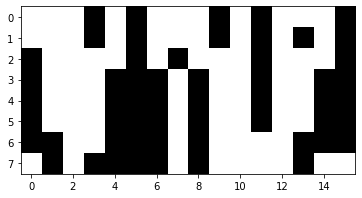

In [67]:
img = rgbtogray(cv2.imread(name1).astype(np.double)/255.)
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
img = rgbtogray(cv2.imread(name1).astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res = theta_psize*n_theta_patches, 
                            rho_res = rho_psize*n_rho_patches,method = "Daug", plot = True)
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, alpha=0.4, omega=4)
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)


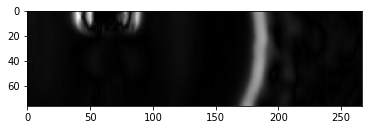

dist right:  192.0


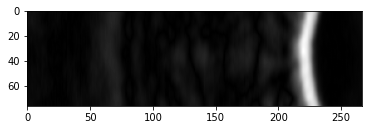

dist left:  44.5


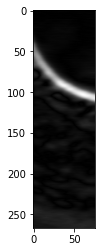

dist top:  100.0


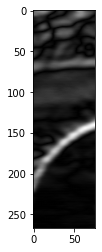

dist bottom:  106.0


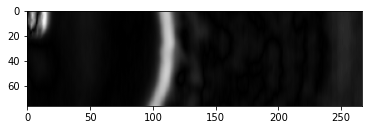

dist right:  118.0


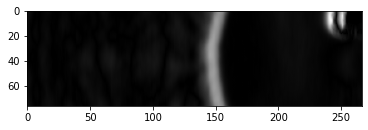

dist left:  118.5


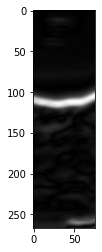

dist top:  120.0


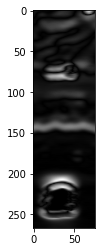

dist bottom:  60.0


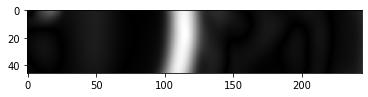

120.0 120.0


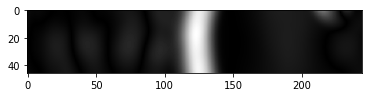

133.0 129.0
Estimated pupil radius:  126
Estimated pupil center:  [321, 575]
Optimal location and radius:  
x=569.0
y=314.0
r=120.0
Estimated iris radius:  273
Optimal location and radius:  
x=563.0
y=310.0
r=268.0


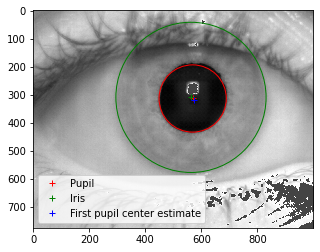

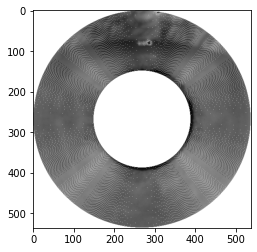

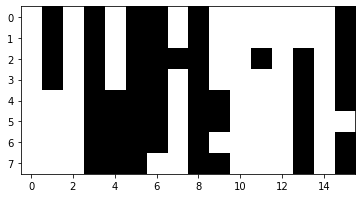

In [68]:
img = rgbtogray(cv2.imread(name2).astype(np.double)/255.)
pup_center, pup_r, iris_center, iris_r = FindPupilIris(img, filter_size=3, sigma=1.0, lateral=True, plot_img=None)
img = rgbtogray(cv2.imread(name2).astype(np.double)/255.)

transf_img = transform_iris(img, pup_center, pup_r, iris_center, iris_r, theta_res = theta_psize*n_theta_patches, 
                            rho_res = rho_psize*n_rho_patches,method = "Daug", plot = True)
iriscode = calculate_iris_code(transf_img, theta_psize=theta_psize, r_psize=rho_psize, alpha=0.4, omega=4)
plt.imshow(iriscode.reshape([n_rho_patches, n_theta_patches*2]), cmap="gray", vmin=0., vmax=1.)
